# Topic Modeling PubMed Abstracts with Latent Dirichlet Analysis
## bigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [3]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [4]:
filename = '../data/pubmed_cleaned_no_outliers.csv'

In [5]:
#read in the data
df = pd.read_csv(filename).set_index('pmid')

In [6]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'date', 'citations', 'len_text',
       'len_title', 'days_live'],
      dtype='object')

In [7]:
#remove non-text, non-Y columns
df.drop(columns = ['Unnamed: 0', 'date', 'len_text', 'len_title', 'days_live'], inplace=True)

#### Combine Title & Abstract

In [8]:
df['text'] = (df['title'] + ' ' + df['text'])

In [9]:
df = df.drop(columns = 'title')

#### Remove Punctuation & Make Lowercase

In [10]:
df['text'] = df['text'].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

In [11]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [15]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [16]:
#!spacy download en_core_web_lg

In [17]:
nlp = spacy.load('en_core_web_lg')

In [18]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [19]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [20]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [21]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
#check out the dictionary

len(id2word)

14912

### Build LDA Mallet Model

In [24]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [25]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.45193401397060684


In [26]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [27]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.053126  0.273344       1        1  10.438649
1     -0.302609 -0.065250       2        1   9.855878
2      0.248256  0.070945       3        1  10.173793
3      0.091546 -0.105430       4        1   9.688042
4      0.055994  0.216831       5        1   9.400345
5     -0.056153  0.072947       6        1  10.110135
6     -0.163434 -0.091930       7        1   9.822888
7      0.231897 -0.160691       8        1   9.914219
8     -0.010895 -0.252840       9        1   9.804800
9     -0.041474  0.042073      10        1  10.791250, topic_info=         Term         Freq        Total Category  logprob  loglift
30       data  4426.000000  4426.000000  Default  30.0000  30.0000
71    machine  4356.000000  4356.000000  Default  29.0000  29.0000
201  learning  3059.000000  3059.000000  Default  28.0000  28.0000
68      learn  2434.000000  2434.000000  Default  27.0000  27.0000
108     study  2468.000000  2468.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
58   identify   431.704964  1056.557081  Topic10  -4.3963   1.3314
513   predict   310.911605   841.467267  Topic10  -4.7245   1.2308
61    include   365.531219  1426.446057  Topic10  -4.5627   0.8648
6        base   310.911605   951.747275  Topic10  -4.7245   1.1076
345      high   234.234082   592.599675  Topic10  -5.0077   1.2982

[828 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
399       2  0.599530   ability
399       3  0.145341   ability
399       5  0.003634   ability
399       9  0.250712   ability
2962     10  0.998861  abstract
...     ...       ...       ...
1753      4  0.005995  workflow
1753      9  0.995216  workflow
597       2  0.253188      year
597       3  0.122168      year
597       7  0.625003      year

[1119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#### Compute Optimal Number of Topics Based on Coherence

In [28]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_big.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_big.pkl')

    return model_list, coherence_values, num_topics_list

In [29]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [30]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_big.pkl')
joblib.dump(optimal_model,f'optimal_ldamallet_model_big.pkl')

['optimal_ldamallet_model_big.pkl']

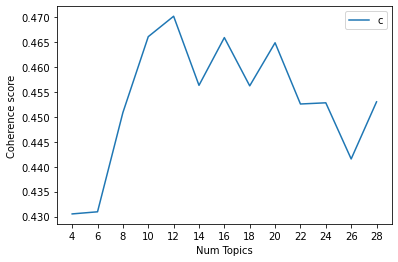

In [31]:
# Show coherence values graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks=range(4,30,2))
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence peaks at 12 topics

### Create & Visualize Model with Optimal Number of Topics

#### LDA Mallet Model: 12 Topics

In [32]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47019433947059514


In [33]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model12_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.017188 -0.030977       1        1  8.023273
1      0.165449 -0.116490       2        1  7.848004
2      0.136991  0.047598       3        1  8.785021
3     -0.205875 -0.223166       4        1  8.367324
4      0.021433 -0.208487       5        1  8.054701
5      0.054183  0.168561       6        1  8.182159
6     -0.058977  0.095686       7        1  8.290137
7      0.009164  0.046208       8        1  8.440492
8      0.262915 -0.117613       9        1  8.475366
9     -0.262179 -0.051481      10        1  8.092602
10     0.074060  0.239077      11        1  8.491932
11    -0.214351  0.151085      12        1  8.948989, topic_info=                Term         Freq        Total Category  logprob  loglift
71           machine  4292.000000  4292.000000  Default  30.0000  30.0000
30              data  4353.000000  4353.000000  Default  29.0000  29.0000
201         learning  3013.000000  3013.000000  Default  28.0000  28.0000
68             learn  2394.000000  2394.000000  Default  27.0000  27.0000
356            model  2353.000000  2353.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1035  implementation   144.026882   299.562484  Topic12  -5.3068   1.6813
91           provide   225.744258  1613.285705  Topic12  -4.8574   0.4470
61           include   208.379321  1426.538046  Topic12  -4.9375   0.4900
63       information   153.220080   833.181852  Topic12  -5.2450   0.7203
449          require   146.069814   478.372573  Topic12  -5.2927   1.2273

[985 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
399       4  0.347555      ability
399      11  0.651208      ability
1541      4  0.981454      absence
2962      3  0.993657     abstract
599      11  0.971242  accommodate
...     ...       ...          ...
597       1  0.112482         year
597       3  0.233891         year
597       4  0.169615         year
597       5  0.108911         year
597      11  0.373154         year

[1379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

### Find the Dominant Topic in Each Document

In [34]:
pd.set_option('max_colwidth', 100)

In [35]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [36]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [37]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical","[future, medical, diagnostic, large, digitized, database, electronic_health, record, mandate, am..."


#### Find the most representative document for each topic

In [38]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [47]:
# Show representative topics and keywords
rep_docs = pd.merge(doc_topics_sorteddf_mallet,df, how='inner', left_index=True, right_index=True)


In [49]:
rep_docs.drop(columns = 'Text', inplace=True)

In [50]:
rep_docs

,Topic_Num,Topic_Perc_Contrib,Keywords,text,citations
pmid,,,,,
31936321,0.0,0.5435,"drug, development, design, model, approach, computational, modeling, target, recent, drug_discovery",machinelearningassisted de novo design of organic molecules and polymers: opportunities and chal...,7
25756377,1.0,0.5198,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...",an overview of the prediction of protein dnabinding sites interactions between proteins and dna ...,16
31526946,2.0,0.5179,"study, review, research, result, literature, article, method, paper, identify, include",half a century of computer methods and programs in biomedicine: a bibliometric analysis from 197...,1
33000054,3.0,0.4521,"patient, disease, clinical, risk, outcome, management, assessment, improve, treatment, cardiovas...",predicting cardiac arrest in the emergency department inhospital cardiac arrest remains a leadin...,0
29705713,4.0,0.5407,"study, brain, biomarker, disorder, disease, individual, approach, identify, pattern, functional",the neural markers of mri to differentiate depression and panic disorder depression and panic di...,2
30337064,5.0,0.4976,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide",computeraided diagnosis of glaucoma using fundus images: a review background and objectives: ...,4
32414188,6.0,0.4987,"system, technology, challenge, sensor, device, review, signal, detection, work, solution",future is unlicensed: private 5g unlicensed network for connecting industries of future this pap...,0
26941766,7.0,0.5031,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene",changing the game: using integrative genomics to probe virulence mechanisms of the stem rust pat...,11
30654138,8.0,0.5982,"model, method, prediction, performance, base, statistical, accuracy, result, predict, predictive",an extensive experimental survey of regression methods regression is a very relevant problem in ...,8


#### Explore Relationship Between Dominant Topic and Number of Citations

In [40]:
df.head()

,text,citations
pmid,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10


In [41]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical","[future, medical, diagnostic, large, digitized, database, electronic_health, record, mandate, am..."


In [42]:
#merge on pmid index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [43]:
combined_df.columns

Index(['text', 'citations', 'Document_No', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [44]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [45]:
combined_df.head()

,text,citations,Dominant_Topic,Topic_Perc_Contrib,Keywords
pmid,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide"
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene"
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide..."
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide..."
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical"


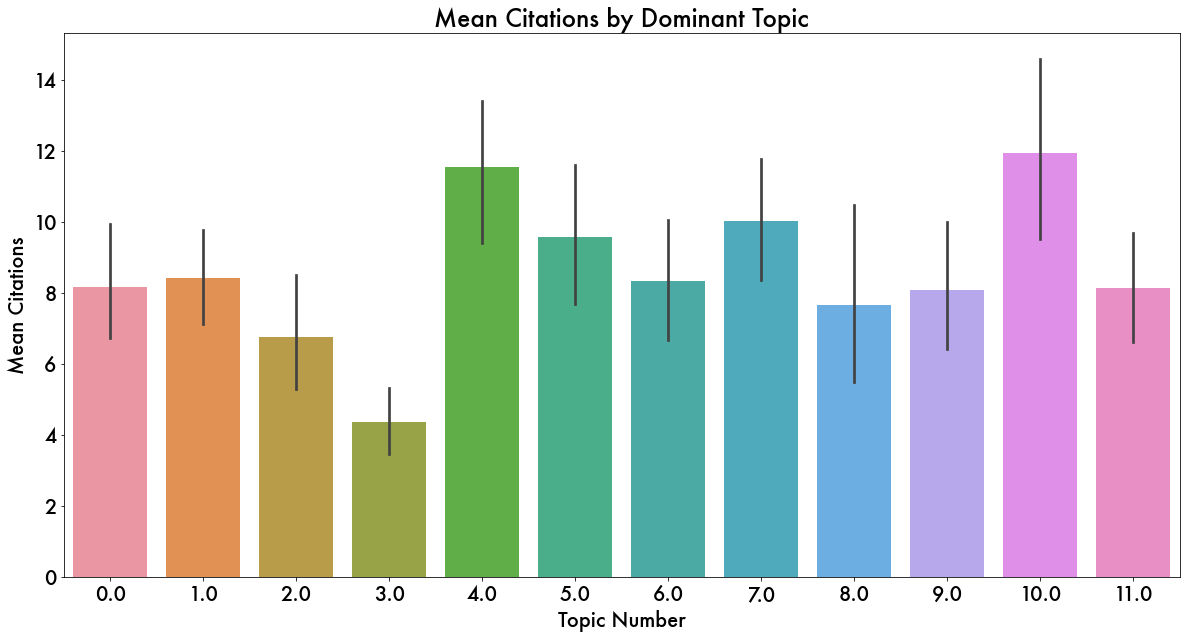

In [51]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='citations');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Citations by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Citations',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_mean_citations_trigram_model.jpg',  bbox_inches = "tight")

#### Model Citations by Topic

In [84]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [85]:
df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [86]:
df.columns

Index(['text', 'citations', 'Topic_Perc_Contrib', 'Keywords',
       'Dominant_Topic_01', 'Dominant_Topic_02', 'Dominant_Topic_03',
       'Dominant_Topic_04', 'Dominant_Topic_05', 'Dominant_Topic_06',
       'Dominant_Topic_07', 'Dominant_Topic_08', 'Dominant_Topic_09',
       'Dominant_Topic_11'],
      dtype='object')

In [87]:
import statsmodels.api as sm

In [88]:
X = df.drop(columns=['text','citations','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = df['citations']

In [89]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.414
Date:                Mon, 10 May 2021   Prob (F-statistic):           3.49e-06
Time:                        22:06:23   Log-Likelihood:                -11412.
No. Observations:                2809   AIC:                         2.285e+04
Df Residuals:                    2798   BIC:                         2.291e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.1720      0.844      9.687      0.000       6.518       9.826
Dominant_Topic_01     1.9313      1.076      1.795      0.073      -0.179       4.041
Dominant_Topic_02    -1.4205      1.384     -1.026      0.305      -4.134       1.293
Dominant_Topic_03    -3.8051      1.274     -2.987      0.003      -6.303      -1.307
Dominant_Topic_04     3.3518      1.225      2.737      0.006       0.951       5.753
Dominant_Topic_05     1.3856      1.204      1.151      0.250      -0.975       3.747
Dominant_Topic_06     0.1526      1.253      0.122      0.903      -2.305       2.611
Dominant_Topic_07     1.8525      1.187      1.561      0.119      -0.474       4.180
Dominant_Topic_08    -0.5227      1.415     -0.370      0.712      -3.296       2.251
Dominant_Topic_09    -0.1057      1.261     -0.084      0.933      -2.578       2.367
Dominant_Topic_11    -0.0352      1.187     -0.030      0.976      -2.362       2.292
==============================================================================
Omnibus:                     1944.468   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24249.074
Skew:                           3.241   Prob(JB):                         0.00
Kurtosis:                      15.852   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As compared to Topic 0, only topics 3 and 4 have any effect. 